In [1]:
from matchms.importing import load_from_mgf
spectra_neg = list(load_from_mgf("./Rumex_neg_20230806_all_samples_GNPS_fbmn_quant.mgf"))
spectra_pos = list(load_from_mgf("./Rumex_20230806_all_samples_2_GNPS_fbmn_quant_quant.mgf"))

### The feature_ids of pos and neg have to be separated

In [3]:
for spectrum in spectra_pos:
    feature_id = spectrum.get('feature_id')
    spectrum.set("ionmode_feature_id", "pos_" + feature_id)
    spectrum.set("ionmode", "positive")
for spectrum in spectra_neg:
    feature_id = spectrum.get('feature_id')
    spectrum.set("ionmode_feature_id", "neg_" + feature_id)
    spectrum.set("ionmode", "negative")


In [4]:
spectra = spectra_neg + spectra_pos

In [5]:
from matchms.exporting import save_as_mgf
case_study_spectra_file_name = "./combined_neg_pos_rumex_spectra.mgf"
save_as_mgf(spectra, case_study_spectra_file_name)

dict_keys(['spectra'])


In [11]:
model_file_name = "../../model_benchmarking/ms2deepscore_model.pt"


In [12]:
from ms2deepscore.models import load_model
model = load_model(model_file_name)

In [65]:
from matchms.Pipeline import Pipeline, create_workflow
from ms2deepscore import MS2DeepScore

workflow = create_workflow(
    query_filters=[],
    score_computations=[
        [MS2DeepScore, {"model": model}],
        ],
)
pipeline = Pipeline(workflow)
report = pipeline.run(case_study_spectra_file_name)

2025-04-10 16:43:19,792:WARNING:matchms:Pipeline:No logging file was defined.Logging messages will not be written to file.
2025-04-10 16:43:19,794:WARNING:matchms:SpectrumProcessor:No filters have been specified, so spectra were not filtered


Processing spectra: 2535it [00:00, 2797.36it/s]
2535it [00:58, 42.97it/s]


In [ ]:
pipeline.scores

In [20]:
from matchms.networking import SimilarityNetwork

# Define settings
ms2ds_network = SimilarityNetwork(
    identifier_key="ionmode_feature_id",
    score_cutoff=0.80,  # higher numbers produce more isolated sub-graphs
    max_links=10,  # lower number makes sparser networks
    link_method="mutual",  # mutual means: link is only added if in top list of both nodes
)

# Compute the graph (takes some time)
ms2ds_network.create_network(pipeline.scores, score_name="MS2DeepScore")

In [21]:
# Export to graphml
ms2ds_network.export_to_graphml("ms2ds_graph_rumex_80.graphml")


# Set different threshold for cross-ionization mode

In [68]:
matrix = pipeline.scores.to_array()

In [77]:
neg_start = 0
neg_end = 1417

# Slice the region and apply the condition
submatrix = matrix[neg_start:neg_end, neg_start:neg_end]
submatrix[submatrix < 0.85] = 0

# Put the modified submatrix back (in-place operation already changed the matrix)
matrix[neg_start:neg_end, neg_start:neg_end] = submatrix

In [79]:
pos_start = 1417

# Slice the region and apply the condition
submatrix = matrix[pos_start:, pos_start:]
submatrix[submatrix < 0.85] = 0

# Put the modified submatrix back (in-place operation already changed the matrix)
matrix[pos_start:, pos_start:] = submatrix

In [84]:
from matchms import Scores
scores = Scores(spectra, spectra, is_symmetric=True)
scores.scores.add_dense_matrix(matrix, name="MS2DeepScore")

In [86]:
from matchms.networking import SimilarityNetwork

# Define settings
ms2ds_network = SimilarityNetwork(
    identifier_key="ionmode_feature_id",
    score_cutoff=0.65,  # higher numbers produce more isolated sub-graphs
    max_links=10,  # lower number makes sparser networks
    link_method="mutual",  # mutual means: link is only added if in top list of both nodes
)

# Compute the graph (takes some time)
ms2ds_network.create_network(scores, score_name="MS2DeepScore")
ms2ds_network.export_to_graphml("ms2ds_graph_rumex_pos_neg_65_rest_85.graphml")


# Analyze false negatives


In [27]:
from ms2deepscore import MS2DeepScore
ms2ds_model = MS2DeepScore(model)

In [41]:
import pandas as pd

def create_small_matrix_between_ids(spectra, ids, ):
    selected_spectra = []
    for spectrum in spectra:
        if spectrum.get("ionmode_feature_id") in ids:
            selected_spectra.append(spectrum)
    
    id_labels = [spectrum.get("ionmode_feature_id") for spectrum in selected_spectra]
    scores = ms2ds_model.matrix(selected_spectra, selected_spectra, is_symmetric=True)
    print(pd.DataFrame(scores, columns=id_labels, index=id_labels))
    
create_small_matrix_between_ids(spectra, ids = ["neg_953", "pos_1910", "neg_1262", "neg_1343"])

4it [00:00, 38.68it/s]

           neg_953  neg_1262  neg_1343  pos_1910
neg_953   1.000000  0.808010  0.780000  0.583995
neg_1262  0.808010  1.000000  0.916000  0.583993
neg_1343  0.780000  0.916000  1.000000  0.555995
pos_1910  0.583995  0.583993  0.555995  1.000000


In [42]:
create_small_matrix_between_ids(spectra, ids = ["pos_2612", "neg_4192", "neg_4732"])

3it [00:00, 35.69it/s]

          neg_4192  neg_4732  pos_2612
neg_4192  1.000000  0.691115  0.631504
neg_4732  0.691115  1.000000  0.594492
pos_2612  0.631504  0.594492  1.000000


In [43]:
create_small_matrix_between_ids(spectra, ids = ["pos_5624", "neg_5264"])

2it [00:00, 31.57it/s]

          neg_5264  pos_5624
neg_5264  1.000000  0.523172
pos_5624  0.523172  1.000000


In [52]:
create_small_matrix_between_ids(spectra, ids = ["pos_6917", "neg_7442"])

2it [00:00, 30.94it/s]

          neg_7442  pos_6917
neg_7442  1.000000  0.694666
pos_6917  0.694666  1.000000


In [53]:
create_small_matrix_between_ids(spectra, ids = ["pos_4039", "neg_3072"])

2it [00:00, 36.80it/s]

          neg_3072  pos_4039
neg_3072     1.000     0.664
pos_4039     0.664     1.000


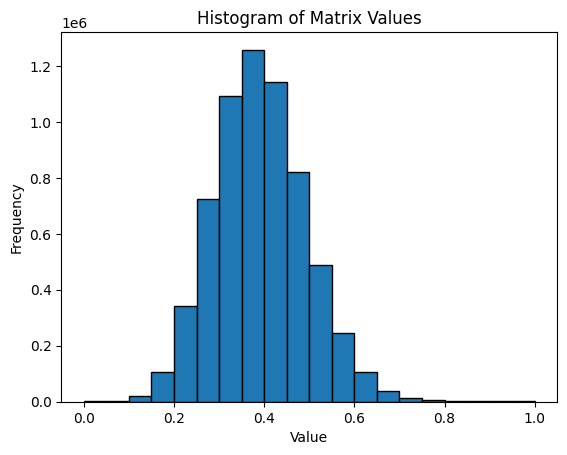

In [50]:
from matplotlib import pyplot as plt
import numpy as np
values = pipeline.scores.to_array().flatten()

# Plot histogram
plt.hist(values, bins=np.linspace(0, 1, 21), edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Matrix Values')
plt.show()

In [56]:
scores = ms2ds_model.matrix(spectra_neg, spectra_neg, is_symmetric=False)


1417it [00:32, 44.02it/s]
1417it [00:35, 40.40it/s]


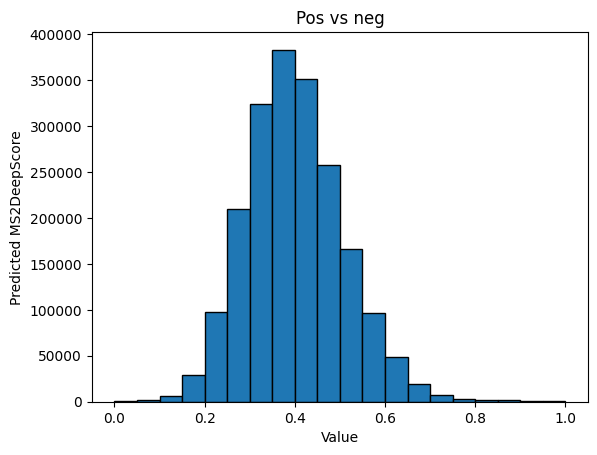

In [55]:
from matplotlib import pyplot as plt
import numpy as np
values = scores.flatten()
# Plot histogram
plt.hist(values, bins=np.linspace(0, 1, 21), edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Predicted MS2DeepScore')
plt.title('Neg vs neg')
plt.show()

1417it [00:31, 45.35it/s]
1118it [00:27, 40.15it/s]


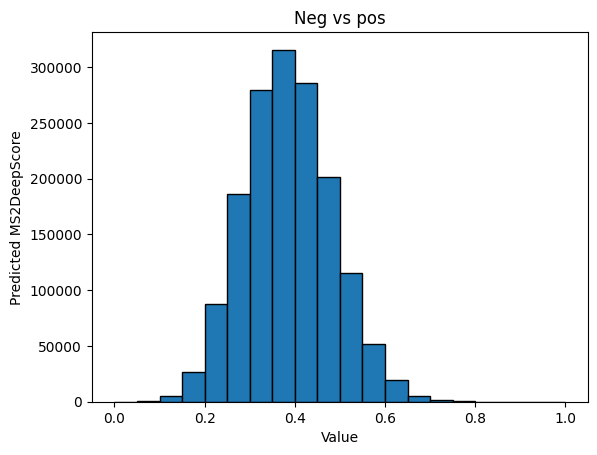

In [59]:
from matplotlib import pyplot as plt
import numpy as np
values = scores.flatten()
# Plot histogram
plt.hist(values, bins=np.linspace(0, 1, 21), edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Predicted MS2DeepScore')
plt.title('Neg vs pos')
plt.show()

1118it [00:26, 42.12it/s]
1118it [00:25, 43.74it/s]


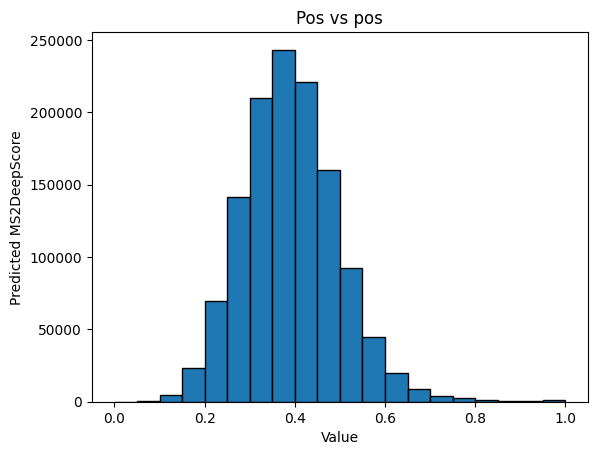

In [58]:
scores = ms2ds_model.matrix(spectra_pos, spectra_pos, is_symmetric=False)
from matplotlib import pyplot as plt
import numpy as np
values = scores.flatten()
# Plot histogram
plt.hist(values, bins=np.linspace(0, 1, 21), edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Predicted MS2DeepScore')
plt.title('Pos vs pos')
plt.show()

# Create umap


### load model

In [4]:
from ms2deepscore.models import load_model
from ms2deepscore import MS2DeepScore

model_file_name = "../../model_benchmarking/ms2deepscore_model.pt"
model = load_model(model_file_name)
ms2ds_model = MS2DeepScore(model)


In [5]:
from matchms.importing import load_from_mgf
from tqdm import tqdm

case_study_spectra_file_name = "./combined_neg_pos_rumex_spectra.mgf"
spectra = list(tqdm(load_from_mgf(case_study_spectra_file_name)))

2535it [00:00, 2751.37it/s]


In [6]:
ms2ds_embeddings = ms2ds_model.get_embedding_array(spectra)

2535it [01:06, 37.88it/s]


In [7]:
ms2ds_embeddings.shape

(2535, 500)

In [8]:
import umap

reducer = umap.UMAP(random_state=42,  # this or whatever your favorite number is
                    n_neighbors=50 ,  # key parameters How global or local the distribution 30, 50
                    min_dist=0.2 , # can the dots overlap if you use 5 they move out a bit. 0.1, 0.2
                    )
reducer.fit(ms2ds_embeddings)

C:\Users\jonge094\AppData\Local\miniconda3\envs\pytorch\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.2, n_neighbors=50, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [9]:
embedding_umap = reducer.transform(ms2ds_embeddings)

In [21]:
import pandas as pd
embedding_umap_df = pd.DataFrame(embedding_umap, 
                                 index = [spectrum.get("ionmode_feature_id") for spectrum in spectra],
                                columns = ["x", "y"])
indexes = embedding_umap_df.index
embedding_umap_df["retention time"] = [spectrum.get("retention_time") for spectrum in spectra]
embedding_umap_df["precursor mz"] = [spectrum.get("precursor_mz") for spectrum in spectra]
embedding_umap_df["ion mode"] = [spectrum.get("ionmode") for spectrum in spectra]

embedding_umap_df["ionmode_feature_id"] = indexes

In [23]:
annotations = pd.read_csv("./rumex_annotations.csv", sep=";")

# Add smiles to annotations table
The annotation table in the paper, did only contain compound names, here we try to derive the smiles. 

In [59]:
from matchms.filtering.metadata_processing.derive_annotation_from_compound_name import _pubchem_name_search
import re
import requests

def iupac_to_smiles(iupac_name):
    url = f"https://opsin.ch.cam.ac.uk/opsin/{iupac_name}.json"
    response = requests.get(url)
    if response.ok:
        return response.json().get("smiles")
    else:
        return None

derived_smiles = []
for annotation in annotations["Compound name"].tolist():
    # remove number behind brackets
    annotation = re.sub(r'\s*\(\d+\)\s*$', '', annotation)
    # remove starting tab
    annotation = annotation.lstrip('\t')
    smiles = None
    # print(annotation)
    if "derivative" in annotation:
        annotation = None
    else:
        compound_annotation = _pubchem_name_search(annotation)
        if len(compound_annotation) > 0:
            smiles = compound_annotation[0]["smiles"]
        else:
            smiles = iupac_to_smiles(annotation)
    if smiles is None:
        print(annotation)
    print(smiles)
    derived_smiles.append(smiles)
        

COC1=C(C=CC(=C1)/C=C/C(=O)NCCCCNCCCN)O
C1=CC=C(C(=C1)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O
Cardinalic acid
None
CN1CC[C@@]23C=C[C@@H](C[C@@H]2OC4=C(C=CC(=C34)C1)OC)O
OC=1C=C(C(=O)OCC2OC(C(C(C2O)O)O)OC)C=C(C1O)O
[C@@H]1([C@H](O)[C@@H](O)[C@H](O)[C@H](O1)CO)OC1=C(/C=C/C(=O)O)C=C(C(=C1)O)OC
OC1=C(C(=O)OC2=C(C(=O)O)C(=CC(=C2)O)C)C(=CC(=C1)O)C
C1=CC=C2C(=C1)C(=CN2)/C=C/C(=O)O
C1=CC=C2C(=C1)C(=CN2)C[C@@H](C(=O)O)N
None
None
C1=CC=C(C=C1)C[C@@H](C(=O)NCC(=O)N[C@@H](CC2=CNC3=CC=CC=C32)C(=O)O)N
C1=CC(=CC(=C1)N)C2=CC=CN2
OC1C(C(OC(C1O)CO)C=1C(=C2C(C=C(OC2=CC1O)CC(C)=O)=O)C)OC1OC(C(C(C1O)O)O)CO
C(COCCOCCOCCOCCO)O
OC[C@H]1OC([C@@H]([C@H]([C@@H]1O)O)O)OC(C=C)O
C1=CC(=C(C=C1/C=C/C(=O)O)O)O
C1=CC2=C(C(=C1)O)NC(=CC2=O)C(=O)O
CC(C)C[C@@H](C(=O)O)NC(=O)[C@H](CCC(=O)O)N
C1=CC(=C(C=C1/C=C/C(=O)O[C@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O)O)O
None
None
1-O,2-O,3-O-(Ethane-1,1,1-triyl)-alpha-D-glucopyranose
None
C1[C@H]([C@H](OC2=C1C(=CC(=C2)O)O[C@H]3C([C@H]([C@@H](C(O3)CO)O)O)O)C4=CC(=C(C=C4)O)O)OC(=O)C5=CC=CC

In [83]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula

def formula_from_smiles(smiles):
    if smiles is None:
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES")
    return CalcMolFormula(mol)

def check_formula_match(smiles, expected_formula):
    actual_formula = formula_from_smiles(smiles)
    return actual_formula == expected_formula

In [ ]:
smiles_matching_formula = []
for i, formula in enumerate(annotations["Molecular formula"].tolist()): 
    formula = formula.lstrip('\t')
    smiles = derived_smiles[i]
    if not derived_smiles[i] is None:
        if not check_formula_match(smiles, formula):
            # print(formula, formula_from_smiles(smiles), smiles, annotation)
            smiles = None
    smiles_matching_formula.append(smiles)

In [ ]:
annotations["smiles"] = smiles_matching_formula

In [86]:
annotations.to_csv("annotations_with_smiles.csv")

In [97]:
annotations

,Compound name,Features ID,Molecular formula,Adduct,RT,Precursor,CSI:FingerID,Tree score,Median absolute mass error (ppm),Structure Similarity %,COSMIC score,Compound classes (ClassyFire),Natural product class,Identification level,Organs,Ion_mode,ionmode_feature_id,smiles
0,Feruloylspermidine (37),224,C17H27N3O3,[M+H]+,"2,22","322,2134","-43,422","37,53","2,603","94,01","0,24",Carboxylic acid and derivatives,ornithine alkaloids,2.0,"Roots, Stems",positive,pos_224,COC1=C(C=CC(=C1)/C=C/C(=O)NCCCCNCCCN)O
1,Datiscetin (71),475,C15H10O6,[M+H]+,"2,4","287,0545","-11,897","55,278","2,806","94,44","0,256",Flavonoids,flavonols,2.0,"Roots, Stems, Leaves",positive,pos_475,C1=CC=C(C(=C1)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O
2,Cardinalic acid (98),706,C16H17NO9,[M+H]+,"2,65","368,0972","-171,028","22,549","4,961","65,22","0,247",Benzoxazines,Phenoxazione alkaloids,2.0,"Roots, Stems, Leaves",positive,pos_706,None
3,Galantamine (100),728,C17H21NO3,[M+H]+,"2,75","288,1596","-56,009","39,66","2,288","93,51","0,4",Amaryllidaceae alkaloids,tyrosine alkaloids,2.0,"Roots, Stems, Leaves",positive,pos_728,CN1CC[C@@]23C=C[C@@H](C[C@@H]2OC4=C(C=CC(=C34)...
4,"(3,4,5-trihydroxy-6-methoxyoxan-2-yl)methyl 3,...",941,\tC14H18O10,[M+H]+,"2,99","347,0977","-40,375","57,318","4,978","91,48","0,176",tannins,Simple phenolic acids,2.0,"Roots, Stems, Leaves",positive,pos_941,OC=1C=C(C(=O)OCC2OC(C(C(C2O)O)O)OC)C=C(C1O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,Emodin (1347),10182,C15H10O5,[M-H]-,"13,72","269,0459","-7,71","58,89","4,374",100,"0,133",Anthracenes,Anthraquinones and anthrones,1.0,"Roots, Stems, Leaves",negative,neg_10182,CC1=CC2=C(C(=C1)O)C(=O)C3=C(C2=O)C=C(C=C3O)O
447,Volkensiflavone (1348),10184,C30H20O10,[M-H]-,"13,73","539,0986","-86,968","15,682","0,455","81,79","0,281",Flavonoids,Flavonoids,2.0,"Roots, Stems, Leaves",negative,neg_10184,C1=CC(=CC=C1[C@@H]2[C@H](C(=O)C3=C(C=C(C=C3O2)...
448,Emodin-3-O-Sulphate (1361),10333,C15H10O9,[M-H]-,"13,71","349,003","-48,477","32,462","1,576","90,13","0,18",Flavonoids,Flavonoids,2.0,"Roots, Stems, Leaves",negative,neg_10333,None
449,4-Hydroxyemodin(1370),10399,C15H10O6,[M-H]-,"13,95","285,041","-26,994","11,901","1,971","97,1","0,088",Hydroxyantrquinones,Anthraquinones and anthrones,2.0,"Roots, Stems, Leaves",negative,neg_10399,CC1=CC(=C2C(=C1O)C(=O)C3=C(C2=O)C(=CC(=C3)O)O)O


# Merge annotations with UMAP embedding table

In [98]:
merged_data = pd.merge(embedding_umap_df, annotations, on="ionmode_feature_id", how= "left")

In [99]:
merged_data = merged_data.fillna("")

In [100]:
merged_data

,x,y,retention time,precursor mz,ion mode,ionmode_feature_id,Compound name,Features ID,Molecular formula,Adduct,...,Tree score,Median absolute mass error (ppm),Structure Similarity %,COSMIC score,Compound classes (ClassyFire),Natural product class,Identification level,Organs,Ion_mode,smiles
0,8.333602,10.601549,123.222,387.1150,negative,neg_4,,,,,...,,,,,,,,,,
1,10.737044,7.441175,121.964,490.9810,negative,neg_8,,,,,...,,,,,,,,,,
2,8.507977,10.749027,123.279,341.0916,negative,neg_16,,,,,...,,,,,,,,,,
3,11.604609,11.128244,123.209,345.0831,negative,neg_17,,,,,...,,,,,,,,,,
4,11.527219,11.167164,123.859,335.0544,negative,neg_19,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,7.906166,7.157118,890.543,181.1451,positive,pos_8862,,,,,...,,,,,,,,,,
2531,6.679704,6.580583,891.688,256.2638,positive,pos_8865,,,,,...,,,,,,,,,,
2532,7.931239,7.342707,889.300,138.1028,positive,pos_8876,,,,,...,,,,,,,,,,
2533,6.797672,5.094965,890.341,158.0926,positive,pos_8877,,,,,...,,,,,,,,,,


In [ ]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [91]:
import plotly.express as px
import numpy as np


# Create scatter plot using Plotly Express
fig = px.scatter(merged_data.iloc[::-1],
    x="x",
    y="y",
    color="ion mode",
    color_discrete_map={"positive": "#C6DBEF", "negative": "#FCBBA1"},

    # color_continuous_scale="viridis",
    size_max=50,
    opacity=1.0,
    title='UMAP projection MS2DeepScore embeddings',
    hover_data={"x": False,
                "y": False,
                # "fraction": True,
                # "precursor_mz_difference": False,
               "ion mode": True,
               # "ms2query_model_prediction": False,
               # "smiles": True,
               "Compound name": True,
                "precursor mz": True, 
               "retention time": True,
                "smiles": True,
               "ionmode_feature_id": True},
    # symbol="cf_superclass",
    width=800,
    height=800,
)
# Update background colors
fig.update_layout(
    plot_bgcolor='white',  # Set the plot area background color
    paper_bgcolor='white',    # Set the figure background color
)

# Update grid line colors
fig.update_xaxes(
    gridcolor='gray',          # Grid lines on x-axis
    zerolinecolor='gray'      # Line at x=0
)
fig.update_yaxes(
    gridcolor='gray',          # Grid lines on y-axis
    zerolinecolor='gray'      # Line at y=0
)

fig.update_traces(marker=dict(size=5))  # Increase size to 12 (default is typically smaller)

fig.show()

In [37]:
import plotly.express as px
import numpy as np

# Create scatter plot using Plotly Express
fig = px.scatter(merged_data.iloc[::-1],
    x="x",
    y="y",
    color="Natural product class",
    color_discrete_map={"-": 'lightgrey'},

    # color_continuous_scale="viridis",
    size_max=50,
    opacity=1.0,
    title='UMAP projection MS2DeepScore embeddings',
    hover_data={"x": False,
                "y": False,
                # "fraction": True,
                # "precursor_mz_difference": False,
               "ion mode": True,
               # "ms2query_model_prediction": False,
               # "smiles": True,
               "Compound name": True,
                "precursor mz": True, 
               "retention time": True,
               "ionmode_feature_id": True},
    # symbol="cf_superclass",
    width=800,
    height=800,
)
# Update background colors
fig.update_layout(
    plot_bgcolor='white',  # Set the plot area background color
    paper_bgcolor='white',    # Set the figure background color
)

# Update grid line colors
fig.update_xaxes(
    gridcolor='gray',          # Grid lines on x-axis
    zerolinecolor='gray'      # Line at x=0
)
fig.update_yaxes(
    gridcolor='gray',          # Grid lines on y-axis
    zerolinecolor='gray'      # Line at y=0
)

fig.update_traces(marker=dict(size=5))  # Increase size to 12 (default is typically smaller)

fig.show()

In [92]:
port = 8000

In [108]:
import pandas as pd
import plotly.express as px

import molplotly

fig = px.scatter(merged_data,
    x="x",
    y="y",
    color="ion mode",
    symbol="Natural product class",
    width=1200,
    height=800,
)

# add molecules to the plotly graph - returns a Dash app
app = molplotly.add_molecules(fig=fig,
                              df=merged_data,
                              smiles_col='smiles',
                              color_col="ion mode",
                              caption_cols=['retention time', "ion mode", "precursor mz", "Compound name", "Natural product class"],
                              show_coords=False,
                              symbol_col="Natural product class"
                            )

port += 1 # If you want to recreate a plot the port has to not be used before (this makes it easy to not forget increasing the port)

# run Dash app inline in notebook (or in an external server)
app.run_server(mode='inline', port=port, height=1000)

C:\Users\jonge094\AppData\Roaming\Python\Python39\site-packages\dash\dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



In [ ]:
Between x: 13.5=14 and y: 9-9.5 nice positive neg kaempferol derivatives.

In [ ]:
Exact match: 9, 10 

In [ ]:
Less good but representative: 8, 5

In [ ]:
Exact match 13.8, 9.1

In [ ]:
Almost exact match and multiple good matches: 14.6 - 9.2